In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from ipywidgets import interact, FloatSlider, Dropdown, fixed
from IPython.display import display

# Словарь файлов и соответствующих им названий столбцов
files = {
    'tksg.csv': 'TCSG',
    'yandex.csv': 'YDEX',
    'vk.csv': 'VKCO',
    'rostelecom.csv': 'RTKM',
    'usd_rub.csv': 'USD_RUB',
    'brent.csv': 'Brent',
    'bitcoin.csv': 'BTC_USD'
}

# Чтение и отображение первых и последних 5 строк каждого файла и статистики
for file_name, column_name in files.items():
    try:
        df = pd.read_csv(file_name)
        print(f"\nСтатистика файла {file_name}:")
        print(f"Количество строк: {len(df)}")
        print(f"Количество столбцов: {len(df.columns)}")
        
        print("\nПервые 5 строк файла:")
        print(df.head())
        print("\nПоследние 5 строк файла:")
        print(df.tail())
        print("-" * 80)
    except FileNotFoundError:
        print(f"Файл {file_name} не найден")
    except Exception as e:
        print(f"Ошибка при чтении файла {file_name}: {str(e)}")


Статистика файла tksg.csv:
Количество строк: 1378
Количество столбцов: 7

Первые 5 строк файла:
         Дата      Цена     Откр.     Макс.      Мин.    Объём  Изм. %
0  01.06.2025  3.195,00  3.193,60  3.195,00  3.195,00  117,08K   0,00%
1  31.05.2025  3.195,00  3.193,60  3.202,40  3.193,60  117,08K   0,10%
2  30.05.2025  3.191,80  3.176,60  3.216,60  3.164,80    2,27M   0,54%
3  29.05.2025  3.174,80  3.228,40  3.228,40  3.165,80    2,91M  -1,56%
4  28.05.2025  3.225,00  3.112,20  3.227,00  3.110,40    5,15M   3,79%

Последние 5 строк файла:
            Дата      Цена     Откр.     Макс.      Мин.   Объём  Изм. %
1373  05.11.2019  1.198,00  1.217,80  1.220,00  1.197,40  61,35K  -1,32%
1374  01.11.2019  1.214,00  1.218,40  1.219,00  1.212,60  16,63K  -0,16%
1375  31.10.2019  1.216,00  1.221,40  1.223,80  1.210,20  19,33K  -0,08%
1376  30.10.2019  1.217,00  1.225,00  1.227,00  1.212,80  36,69K  -0,23%
1377  29.10.2019  1.219,80  1.202,00  1.226,00  1.200,20  68,38K   1,14%
-------------


Итоговый датафрейм:

Первые 5 строк:
           Дата    TCSG    YDEX    VKCO   RTKM  USD_RUB  Brent  BTC_USD
1137 2020-07-03  1456.0  3549.6  1754.8  88.09  71.2680  42.73   9061.4
1136 2020-07-06  1503.8  3639.0  1852.0  89.10  71.5550  43.05   9340.8
1135 2020-07-07  1490.0  3598.8  1873.0  88.00  71.1981  42.94   9258.0
1134 2020-07-08  1460.0  3581.8  1838.6  86.60  71.1012  43.28   9436.9
1133 2020-07-09  1470.2  3637.8  1808.0  85.60  70.6570  42.30   9233.4

Последние 5 строк:
        Дата    TCSG    YDEX   VKCO   RTKM  USD_RUB  Brent   BTC_USD
4 2025-05-26  3023.2  3917.0  241.7  52.79   79.760  64.22  109452.0
3 2025-05-27  3107.2  3992.5  256.7  55.34   80.250  63.76  108938.2
2 2025-05-28  3225.0  4165.0  262.4  55.82   79.875  64.31  107781.8
1 2025-05-29  3174.8  4117.0  257.1  55.22   76.900  63.30  105571.4
0 2025-05-30  3191.8  4172.0  260.8  57.87   77.500  62.58  103990.6

Информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
Index: 1138 entries, 1137 to 0
D

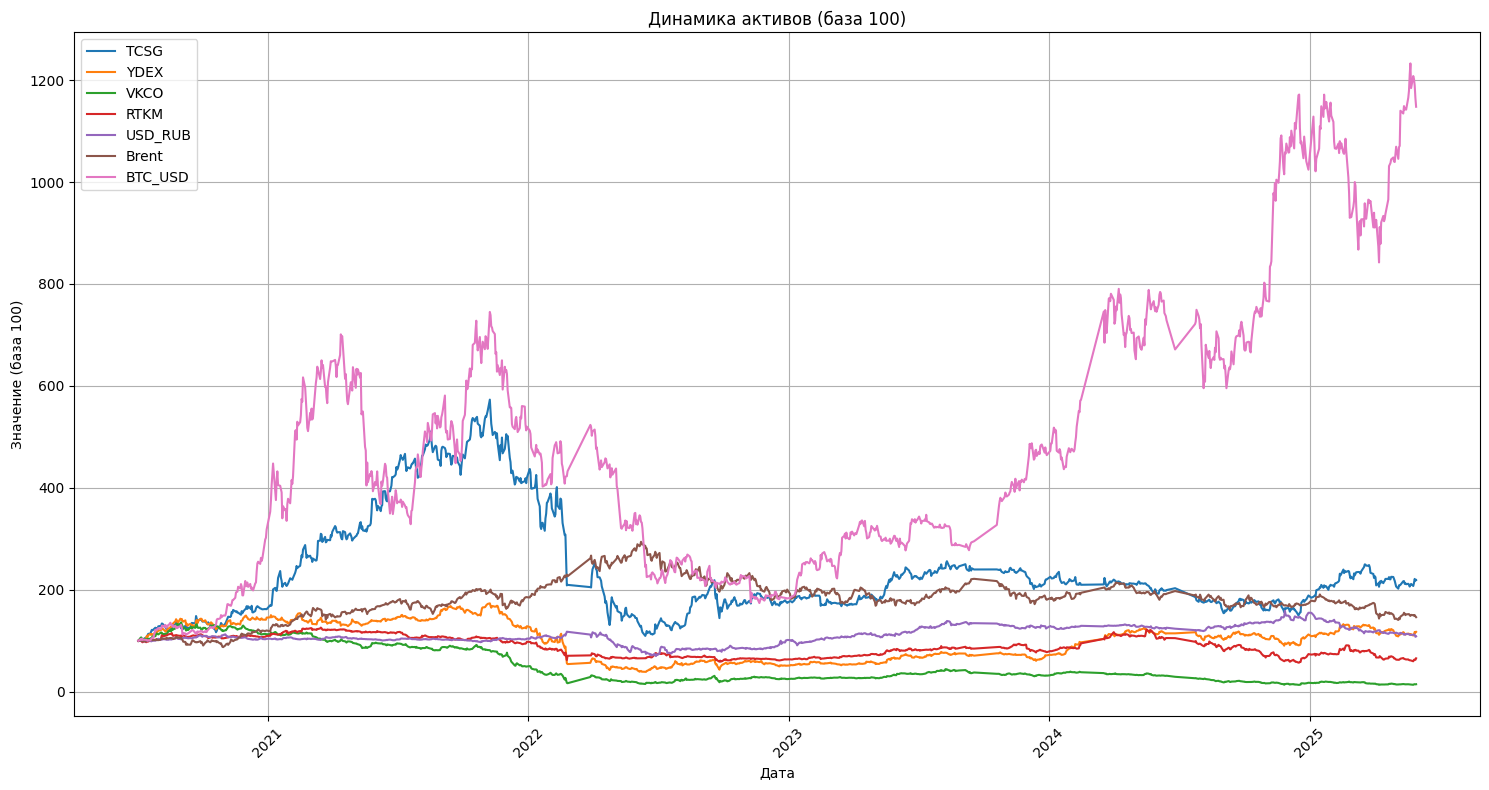

In [28]:
# 1 обьединение данных в единый временной ряд методом inner join

# Функция для конвертации строк с числами в float
def convert_to_float(value):
    try:
        # Удаляем точку как разделитель тысяч и заменяем запятую на точку для десятичного разделителя
        cleaned_value = str(value).replace('.', '').replace(',', '.')
        return float(cleaned_value)
    except (ValueError, TypeError):
        return value  # Возвращаем исходное значение, если конвертация не удалась

# Создание единого датафрейма final_df
dfs = []
for file_name, column_name in files.items():
    try:
        df = pd.read_csv(file_name)
        # Выбираем только нужные столбцы и переименовываем столбец с ценой
        df = df[['Дата', 'Цена']].rename(columns={'Цена': column_name})
        dfs.append(df)
    except FileNotFoundError:
        print(f"Файл {file_name} не найден")
    except Exception as e:
        print(f"Ошибка при чтении файла {file_name}: {str(e)}")

# Объединение всех датафреймов
if dfs:
    # Начинаем с первого датафрейма
    final_df = dfs[0]
    # Последовательно объединяем с остальными
    for df in dfs[1:]:
        final_df = pd.merge(final_df, df, on='Дата', how='inner')
    
    # Сортировка по дате
    final_df['Дата'] = pd.to_datetime(final_df['Дата'], format='%d.%m.%Y')
    final_df = final_df.sort_values('Дата')
    
    # Преобразование данных в числовой формат
    for column in final_df.columns:
        if column != 'Дата':
            final_df[column] = final_df[column].apply(convert_to_float)
    
    # Вывод информации и статистики до очистки
    print("\nИтоговый датафрейм:")
    print("\nПервые 5 строк:")
    print(final_df.head())
    print("\nПоследние 5 строк:")
    print(final_df.tail())
    print("\nИнформация о датафрейме:")
    print(final_df.info())
    print("\nСтатистика датафрейма:")
    print(final_df.describe())
    
    # Построение графика
    plt.figure(figsize=(15, 8))
    
    # Нормализация данных (приведение к базе 100)
    normalized_df = final_df.copy()
    for column in normalized_df.columns:
        if column != 'Дата':
            normalized_df[column] = normalized_df[column] / normalized_df[column].iloc[0] * 100
    
    # Построение графика для каждого актива
    for column in normalized_df.columns:
        if column != 'Дата':
            plt.plot(normalized_df['Дата'], normalized_df[column], label=column)
    
    plt.title('Динамика активов (база 100)')
    plt.xlabel('Дата')
    plt.ylabel('Значение (база 100)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("Не удалось создать датафрейм из-за ошибок при чтении файлов")


Итоговый датафрейм после очистки от выбросов:

Первые 5 строк:
           Дата    TCSG    YDEX    VKCO   RTKM  USD_RUB  Brent  BTC_USD
1036 2020-11-24  2201.2  4935.8  2175.6  95.20  75.3850  47.83  19148.3
1035 2020-11-25  2304.6  4946.0  2197.0  95.03  75.4610  48.77  18720.7
1034 2020-11-26  2244.0  4985.2  2256.8  94.85  75.5977  47.78  17147.5
1033 2020-11-27  2289.8  5115.0  2280.8  96.18  75.8050  48.17  17134.7
1032 2020-11-30  2360.0  5278.0  2193.0  95.67  76.3282  47.63  19694.4

Последние 5 строк:
        Дата    TCSG    YDEX   VKCO   RTKM  USD_RUB  Brent   BTC_USD
4 2025-05-26  3023.2  3917.0  241.7  52.79   79.760  64.22  109452.0
3 2025-05-27  3107.2  3992.5  256.7  55.34   80.250  63.76  108938.2
2 2025-05-28  3225.0  4165.0  262.4  55.82   79.875  64.31  107781.8
1 2025-05-29  3174.8  4117.0  257.1  55.22   76.900  63.30  105571.4
0 2025-05-30  3191.8  4172.0  260.8  57.87   77.500  62.58  103990.6

Статистика после очистки:
<class 'pandas.core.frame.DataFrame'>
Index

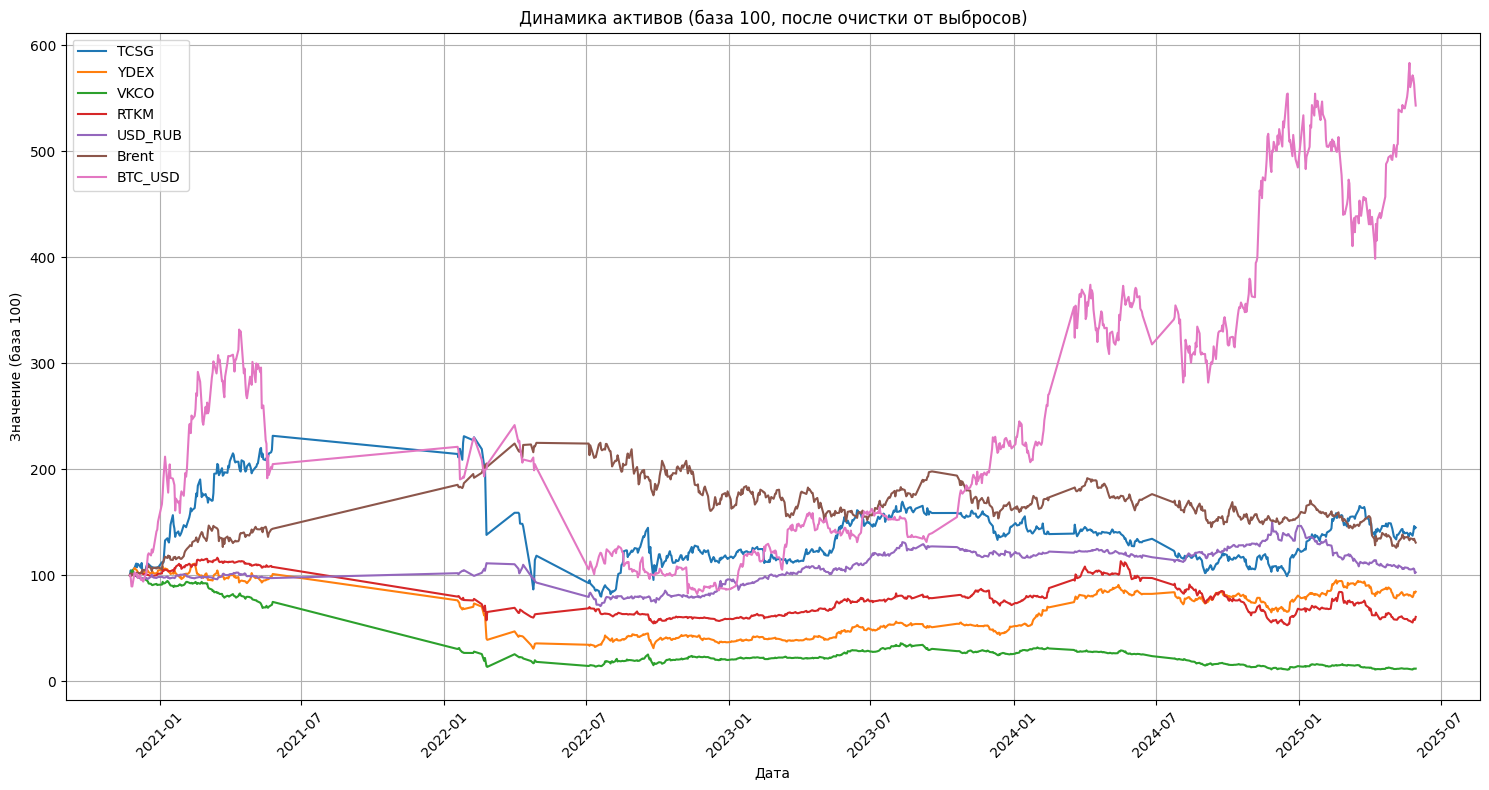

In [30]:
# Очистка от выбросов (менее строгая: удаляем строки, где ВСЕ столбцы являются выбросами)
def remove_outliers(df, columns):
    mask = pd.Series(True, index=df.index)  # Изначально все строки включены
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        # Обновляем маску: строка остается, если значение в столбце НЕ является выбросом
        mask = mask & (df[col].between(lower_bound, upper_bound))
    return df[mask]

# Очистка от выбросов
columns_to_clean = list(files.values())
cleaned_df = remove_outliers(final_df, columns_to_clean)

# Статистика после очистки
print("\nИтоговый датафрейм после очистки от выбросов:")
print("\nПервые 5 строк:")
print(cleaned_df.head())
print("\nПоследние 5 строк:")
print(cleaned_df.tail())
print("\nСтатистика после очистки:")
print(cleaned_df.info())
# print(cleaned_df.describe())

# Построение графика для очищенных данных
plt.figure(figsize=(15, 8))

# Нормализация данных (приведение к базе 100) для очищенного датафрейма
normalized_df = cleaned_df.copy()
for column in normalized_df.columns:
    if column != 'Дата':
        normalized_df[column] = normalized_df[column] / normalized_df[column].iloc[0] * 100

# Построение графика для каждого актива
for column in normalized_df.columns:
    if column != 'Дата':
        plt.plot(normalized_df['Дата'], normalized_df[column], label=column)

plt.title('Динамика активов (база 100, после очистки от выбросов)')
plt.xlabel('Дата')
plt.ylabel('Значение (база 100)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [43]:
# 3. Нормализация (Z-нормализация)
# normalized_df = final_df.copy()
# for col in columns_to_clean:
#     mean = final_df[col].mean()
#     std = final_df[col].std()
#     normalized_df[col] = (final_df[col] - mean) / std
#     print(f"\nСтатистика для {col} (до нормализации): mean = {mean:.2f}, std = {std:.2f}")


normalized_df = cleaned_df.copy()
for col in columns_to_clean:
    mean = cleaned_df[col].mean()
    std = cleaned_df[col].std()
    normalized_df[col] = (cleaned_df[col] - mean) / std
    print(f"\nСтатистика для {col} (до нормализации): mean = {mean:.2f}, std = {std:.2f}")

print("\nПример нормализованного датафрейма (первые 5 строк):")
print(normalized_df.head())
print("\nСтатистика после нормализации:")
print(normalized_df.describe())


Статистика для TCSG (до нормализации): mean = 3029.04, std = 624.51

Статистика для YDEX (до нормализации): mean = 3275.91, std = 1124.97

Статистика для VKCO (до нормализации): mean = 687.44, std = 531.22

Статистика для RTKM (до нормализации): mean = 74.38, std = 16.75

Статистика для USD_RUB (до нормализации): mean = 81.70, std = 12.54

Статистика для Brent (до нормализации): mean = 78.49, std = 11.91

Статистика для BTC_USD (до нормализации): mean = 47916.01, std = 26494.31

Пример нормализованного датафрейма (первые 5 строк):
           Дата      TCSG      YDEX      VKCO      RTKM   USD_RUB     Brent  \
1036 2020-11-24 -1.325593  1.475501  2.801398  1.243219 -0.503843 -2.575371   
1035 2020-11-25 -1.160022  1.484568  2.841683  1.233069 -0.497783 -2.496420   
1034 2020-11-26 -1.257059  1.519414  2.954254  1.222321 -0.486884 -2.579570   
1033 2020-11-27 -1.183721  1.634795  2.999433  1.301733 -0.470355 -2.546814   
1032 2020-11-30 -1.071312  1.779688  2.834153  1.271282 -0.428640 -

In [44]:
# 1. Проверка нормальности и характеристик распределения
factors = ['TCSG', 'YDEX', 'VKCO', 'RTKM', 'USD_RUB', 'Brent', 'BTC_USD']
normality_results = []
distribution_stats = []

for factor in factors:
    data = normalized_df[factor].dropna()
    # Тест Шапиро-Уилка
    stat, p_value = stats.shapiro(data)
    conclusion = "Не соответствует нормальному распределению" if p_value < 0.05 else "Соответствует нормальному распределению"
    normality_results.append([factor, stat, p_value, conclusion])

    # Характеристики распределения
    skewness = stats.skew(data)
    kurtosis = stats.kurtosis(data)
    mean = data.mean()
    median = data.median()
    std = data.std()
    min_val = data.min()
    max_val = data.max()
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    
    # Интерпретация асимметрии
    skewness_comment = (
        "Сильная правосторонняя асимметрия" if skewness > 1 else
        "Сильная левосторонняя асимметрия" if skewness < -1 else
        "Умеренная асимметрия" if abs(skewness) > 0.5 else
        "Приблизительно симметричное распределение"
    )
    
    # Интерпретация куртозиса
    kurtosis_comment = (
        "Тяжёлые хвосты (много выбросов)" if kurtosis > 3 else
        "Лёгкие хвосты (меньшая вероятность экстремальных значений, что положительно для моделирования)" if kurtosis < -1 else
        "Нормальные хвосты (умеренное количество выбросов)"
    )
    
    # Дополнительные комментарии для факторов
    factor_comment = (
        "Высокая волатильность из-за влияния криптовалютного рынка и санкций." if factor == 'TCSG' else
        "Зависимость от сырьевых рынков (нефть) и макроэкономической среды." if factor in ['YDEX', 'VKCO', 'RTKM'] else
        "Волатильность связана с экономическими и геополитическими факторами." if factor == 'USD_RUB' else
        "Зависимость от мировых сырьевых рынков." if factor == 'Brent' else
        "Высокая волатильность из-за спекулятивного характера криптовалют."
    )
    
    distribution_stats.append([
        factor, mean, median, std, skewness, kurtosis, min_val, max_val, q1, q3,
        skewness_comment, kurtosis_comment, factor_comment
    ])

# Формирование таблиц результатов
normality_df = pd.DataFrame(normality_results, columns=['Фактор', 'Статистика Шапиро-Уилка', 'p-value', 'Нормальность'])
dist_stats_df = pd.DataFrame(distribution_stats, columns=[
    'Фактор', 'Среднее', 'Медиана', 'Стд. откл.', 'Асимметрия', 'Куртозис',
    'Мин.', 'Макс.', 'Q1', 'Q3', 'Асимметрия (пояснение)', 'Куртозис (пояснение)', 'Комментарий'
]).round(4)

# Вывод таблиц
print("\nРезультаты теста Шапиро-Уилка:")
print(normality_df.to_string(index=False))
# print("\nХарактеристики распределения:")
# print(dist_stats_df.to_string(index=False))


Результаты теста Шапиро-Уилка:
 Фактор  Статистика Шапиро-Уилка      p-value                               Нормальность
   TCSG                 0.929296 5.749032e-19 Не соответствует нормальному распределению
   YDEX                 0.905967 8.731979e-22 Не соответствует нормальному распределению
   VKCO                 0.672748 1.378029e-36 Не соответствует нормальному распределению
   RTKM                 0.897533 1.124322e-22 Не соответствует нормальному распределению
USD_RUB                 0.965587 8.770990e-13 Не соответствует нормальному распределению
  Brent                 0.989275 1.381667e-05 Не соответствует нормальному распределению
BTC_USD                 0.899793 1.922294e-22 Не соответствует нормальному распределению



=== Корреляционный анализ (метод Спирмена) ===


C:\Users\DxDyBoss\AppData\Local\Temp\ipykernel_18928\2866356856.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


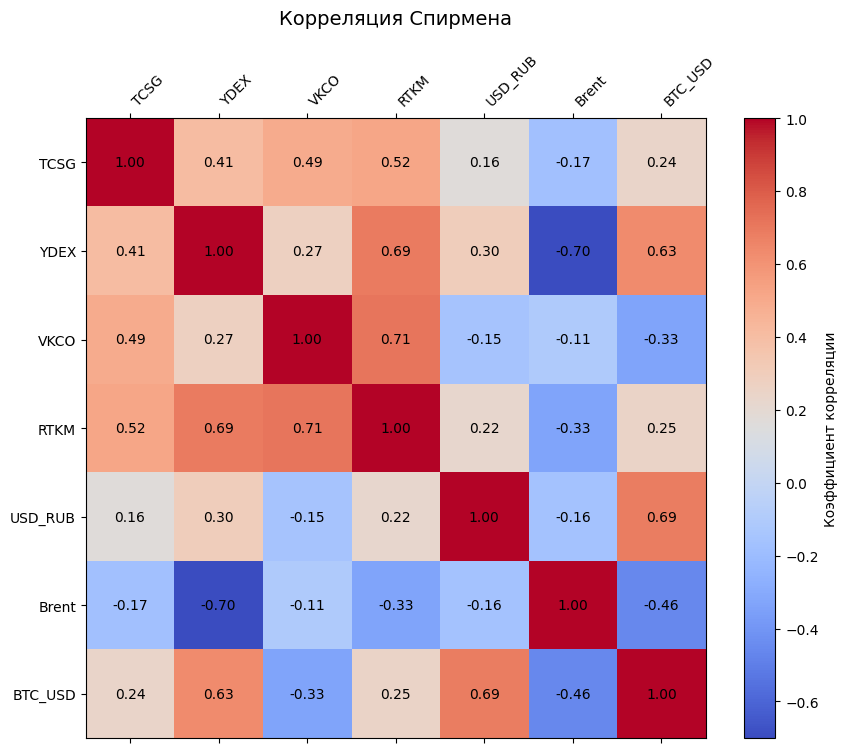

In [45]:
# 3. Корреляционный анализ 
def analyze_correlations():
    print("\n=== Корреляционный анализ (метод Спирмена) ===")
    
    # Корреляция Спирмена
    correlation_matrix = normalized_df[columns_to_clean].corr(method='spearman')
    
    # # Форматирование матрицы для вывода
    # corr_df = correlation_matrix.round(3)  # Округляем до 3 знаков после запятой
    # print("\nМатрица корреляции (Спирмен):")
    # display(corr_df.style.background_gradient(cmap='coolwarm', axis=None).set_caption('Корреляционная матрица (Спирмен)'))

    # Визуализация корреляции
    plt.figure(figsize=(10, 8), dpi=100)
    plt.matshow(correlation_matrix, cmap='coolwarm', fignum=1)
    plt.xticks(range(len(columns_to_clean)), columns_to_clean, rotation=45, ha='left')
    plt.yticks(range(len(columns_to_clean)), columns_to_clean)
    for (i, j), val in np.ndenumerate(correlation_matrix):
        plt.text(j, i, f'{val:.2f}', ha='center', va='center', color='black', fontsize=10)
    plt.title('Корреляция Спирмена', fontsize=14, pad=20)
    plt.colorbar(label='Коэффициент корреляции')
    plt.tight_layout()
    plt.show()

# Выполняем корреляционный анализ
analyze_correlations()


Результаты линейной регрессии (на тестовой выборке):
Компания  USD_RUB (β1)  Brent (β2)  BTC_USD (β3)  Intercept    MAE    MSE
    TCSG        0.0902     -0.1920        0.0058     0.0000 0.7106 0.8737
    YDEX       -0.1115     -0.5771        0.4689     0.0069 0.4859 0.3263
    VKCO       -0.1384     -0.7354       -0.3855     0.0060 0.6003 0.5198
    RTKM        0.1461     -0.4597       -0.1762     0.0031 0.7499 0.8413

Анализ ошибок линейной регрессии (на тестовой выборке):


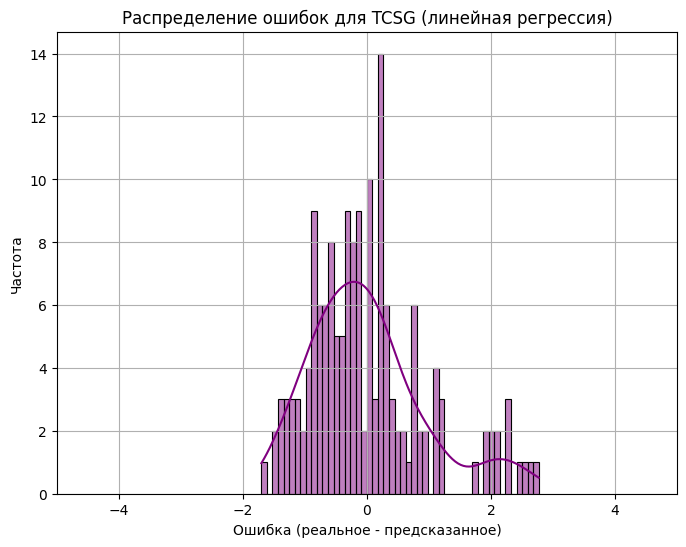

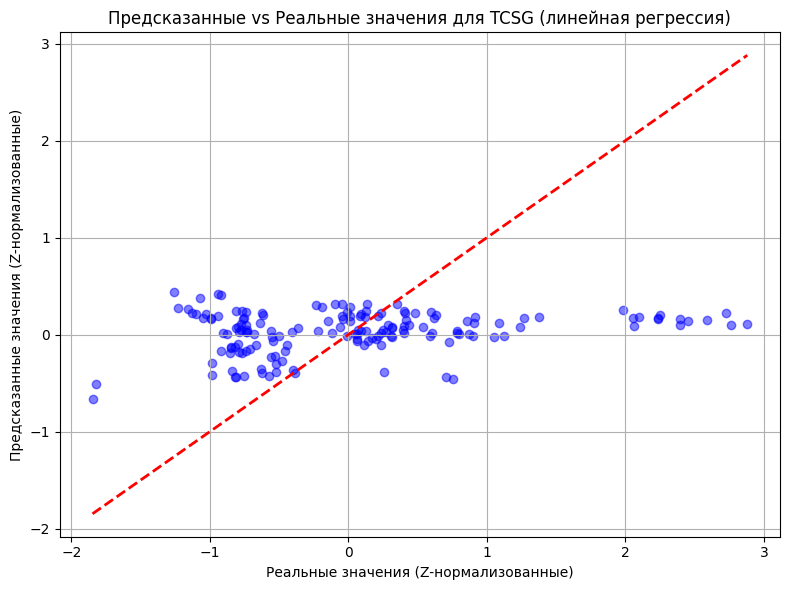

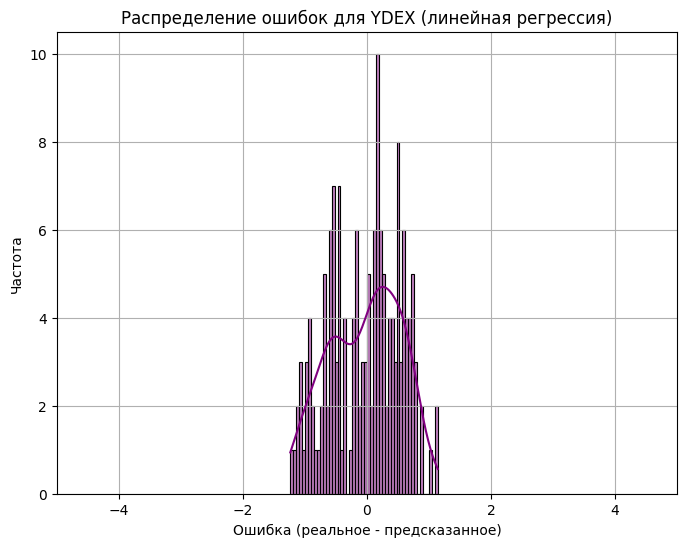

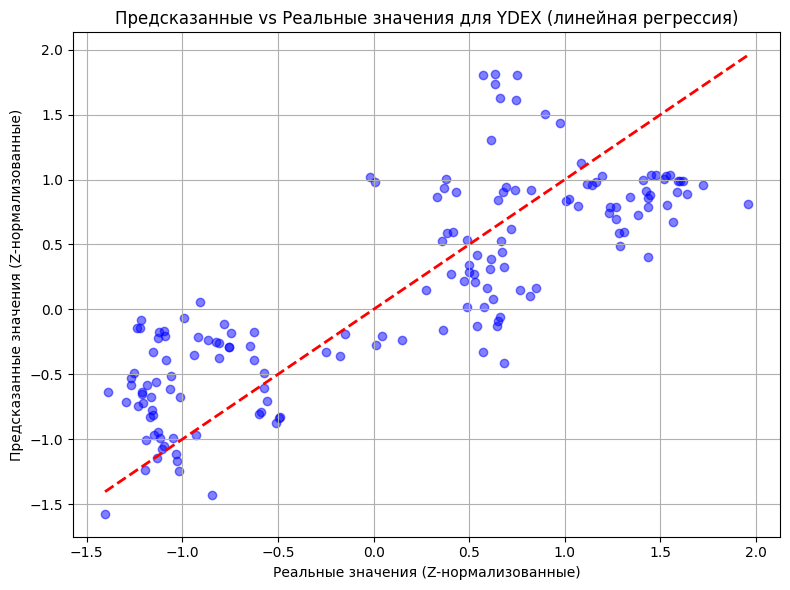

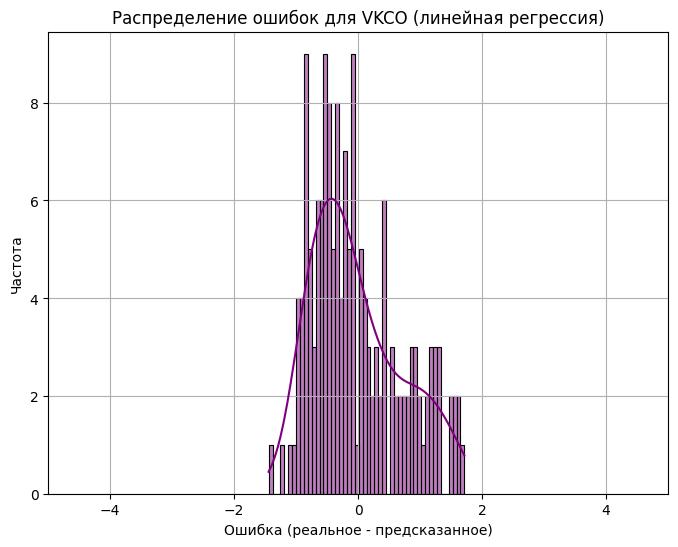

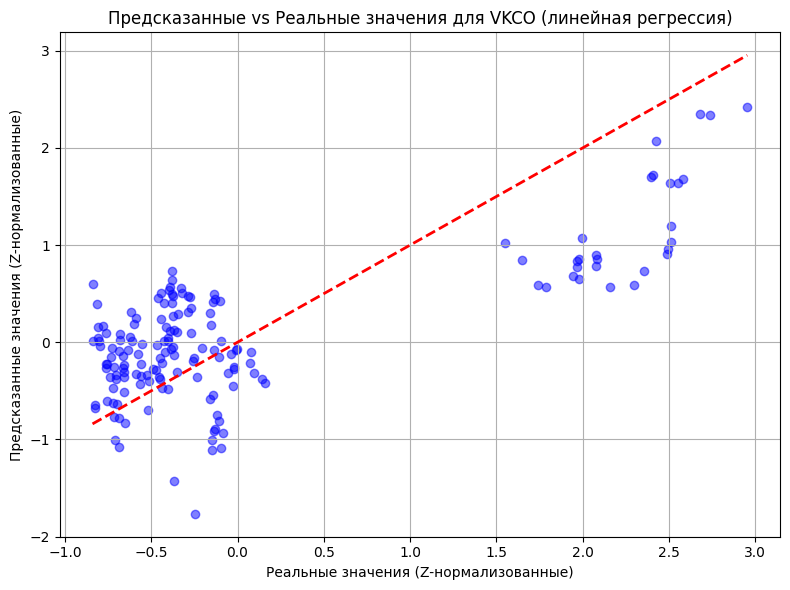

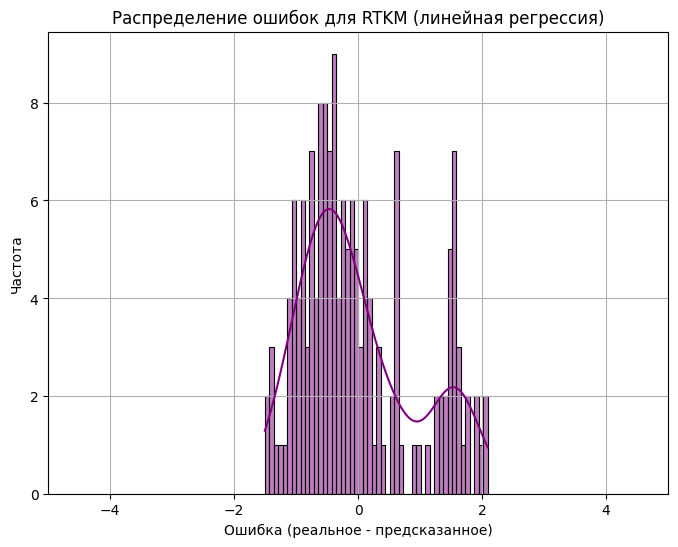

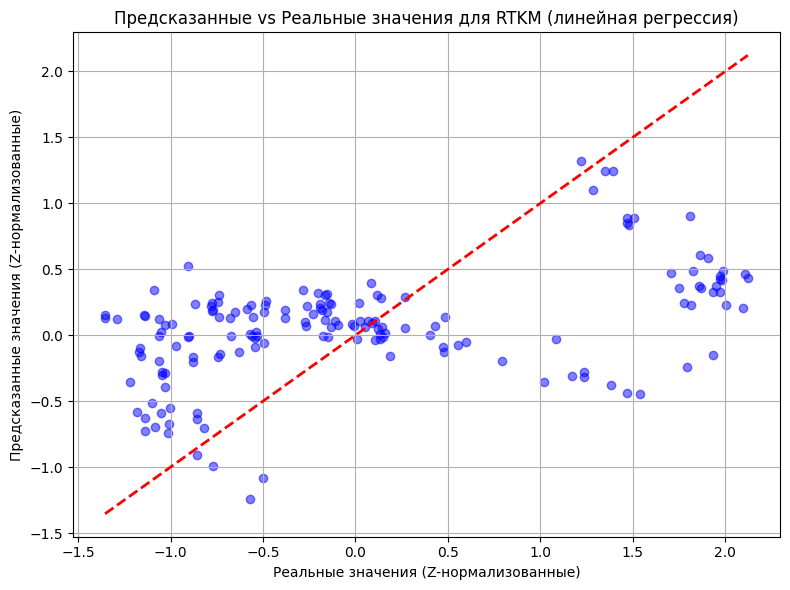

In [46]:
# 2. Модель линейной регрессии
dependent_vars = ['TCSG', 'YDEX', 'VKCO', 'RTKM']
independent_vars = ['USD_RUB', 'Brent', 'BTC_USD']

results_normalized = {}  # Линейная регрессия
X_normalized = normalized_df[independent_vars].dropna()

for y_var in dependent_vars:
    y = normalized_df[y_var].dropna()
    common_index = X_normalized.index.intersection(y.index)
    X_subset = X_normalized.loc[common_index]
    y_subset = y.loc[common_index]
    
    # Разбиение данных
    X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.2, random_state=42)
    
    # Линейная регрессия
    model_lr = LinearRegression()
    model_lr.fit(X_train, y_train)
    y_pred_lr = model_lr.predict(X_test)
    mae_lr = np.mean(np.abs(y_test - y_pred_lr))
    mse_lr = np.mean((y_test - y_pred_lr) ** 2)
    
    results_normalized[y_var] = {
        'y_actual': y_test,
        'y_pred': y_pred_lr,
        'X_test': X_test,
        'model': model_lr,
        'coefficients': dict(zip(independent_vars, model_lr.coef_)),
        'intercept': model_lr.intercept_,
        'MAE': mae_lr,
        'MSE': mse_lr
    }
    
# Формирование таблицы регрессии
results_data = []
for y_var in dependent_vars:
    coeffs = results_normalized[y_var]['coefficients']
    results_data.append([
        y_var,
        coeffs.get('USD_RUB', 0),
        coeffs.get('Brent', 0),
        coeffs.get('BTC_USD', 0),
        results_normalized[y_var]['intercept'],
        results_normalized[y_var]['MAE'],
        results_normalized[y_var]['MSE']
    ])
results_df = pd.DataFrame(
    results_data,
    columns=['Компания', 'USD_RUB (β1)', 'Brent (β2)', 'BTC_USD (β3)', 'Intercept', 'MAE', 'MSE']
).round(4)

print("\nРезультаты линейной регрессии (на тестовой выборке):")
print(results_df.to_string(index=False))

# Анализ ошибок регрессии
print("\nАнализ ошибок линейной регрессии (на тестовой выборке):")
for y_var in dependent_vars:
    errors = results_normalized[y_var]['y_actual'] - results_normalized[y_var]['y_pred']
    error_mean = errors.mean()
    error_std = errors.std()
    error_skewness = stats.skew(errors)
    error_kurtosis = stats.kurtosis(errors)
    
    stat, p = stats.shapiro(errors)
    normality_comment = "Ошибки не соответствуют нормальному распределению" if p < 0.05 else "Ошибки соответствуют нормальному распределению"
    
    error_mean_comment = (
        f"Ошибки в среднем {'смещены вверх' if error_mean > 0.1 else 'смещены вниз' if error_mean < -0.1 else 'близки к нулю'} "
        f"(среднее: {error_mean:.4f})."
    )
    error_std_comment = (
        f"{'Высокая вариабельность ошибок' if error_std > 1 else 'Умеренная вариабельность ошибок' if error_std > 0.5 else 'Низкая вариабельность ошибок'} "
        f"(стандартное отклонение: {error_std:.4f})."
    )
    error_skewness_comment = (
        "Сильная правосторонняя асимметрия ошибок" if error_skewness > 1 else
        "Сильная левосторонняя асимметрия ошибок" if error_skewness < -1 else
        "Умеренная асимметрия ошибок" if abs(error_skewness) > 0.5 else
        "Ошибки симметричны"
    )
    error_kurtosis_comment = (
        "Тяжёлые хвосты ошибок (много выбросов)" if error_kurtosis > 3 else
        "Лёгкие хвосты ошибок (меньшая вероятность экстремальных значений)" if error_kurtosis < -1 else
        "Нормальные хвосты ошибок"
    )
    
    # print(f"\nХарактеристики ошибок для {y_var}:")
    # print(f"- Среднее: {error_mean_comment}")
    # print(f"- Стандартное отклонение: {error_std_comment}")
    # print(f"- Асимметрия: {error_skewness_comment} (значение: {error_skewness:.4f})")
    # print(f"- Куртозис: {error_kurtosis_comment} (значение: {error_kurtosis:.4f})")
    # print(f"- Шапиро-Уилка: stat={stat:.4f}, p={p:.4f}, {normality_comment}")
    
    # Гистограмма ошибок
    plt.figure(figsize=(8, 6))
    sns.histplot(errors, kde=True, bins=50, color='purple')
    plt.title(f'Распределение ошибок для {y_var} (линейная регрессия)')
    plt.xlabel('Ошибка (реальное - предсказанное)')
    plt.ylabel('Частота')
    plt.xlim(-5, 5)
    plt.grid(True)
    plt.show()
    
    # График предсказанных vs реальных значений
    y_actual = results_normalized[y_var]['y_actual']
    y_pred = results_normalized[y_var]['y_pred']
    plt.figure(figsize=(8, 6))
    plt.scatter(y_actual, y_pred, color='blue', alpha=0.5)
    plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'r--', lw=2)
    plt.title(f'Предсказанные vs Реальные значения для {y_var} (линейная регрессия)')
    plt.xlabel('Реальные значения (Z-нормализованные)')
    plt.ylabel('Предсказанные значения (Z-нормализованные)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [47]:
# 3. Модель случайного леса
dependent_vars = ['TCSG', 'YDEX', 'VKCO', 'RTKM']
independent_vars = ['USD_RUB', 'Brent', 'BTC_USD']

results_normalized_rf = {}  # Случайный лес
X_normalized = normalized_df[independent_vars].dropna()

for y_var in dependent_vars:
    y = normalized_df[y_var].dropna()
    common_index = X_normalized.index.intersection(y.index)
    X_subset = X_normalized.loc[common_index]
    y_subset = y.loc[common_index]
    
    # Разбиение данных
    X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.2, random_state=42)
    
    # Случайный лес
    model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
    model_rf.fit(X_train, y_train)
    y_pred_rf = model_rf.predict(X_test)
    mae_rf = np.mean(np.abs(y_test - y_pred_rf))
    mse_rf = np.mean((y_test - y_pred_rf) ** 2)
    
    results_normalized_rf[y_var] = {
        'y_actual': y_test,
        'y_pred': y_pred_rf,
        'X_test': X_test,
        'model': model_rf,
        'feature_importances': dict(zip(independent_vars, model_rf.feature_importances_)),
        'MAE': mae_rf,
        'MSE': mse_rf
    }
    
# Формирование таблицы для случайного леса
results_data_rf = []
for y_var in dependent_vars:
    importances = results_normalized_rf[y_var]['feature_importances']
    results_data_rf.append([
        y_var,
        importances.get('USD_RUB', 0),
        importances.get('Brent', 0),
        importances.get('BTC_USD', 0),
        results_normalized_rf[y_var]['MAE'],
        results_normalized_rf[y_var]['MSE']
    ])
results_df_rf = pd.DataFrame(
    results_data_rf,
    columns=['Компания', 'USD_RUB (важность)', 'Brent (важность)', 'BTC_USD (важность)', 'MAE', 'MSE']
).round(4)

print("\nРезультаты случайного леса (на тестовой выборке):")
print(results_df_rf.to_string(index=False))

# Анализ ошибок случайного леса
print("\nАнализ ошибок случайного леса (на тестовой выборке):")
for y_var in dependent_vars:
    errors = results_normalized_rf[y_var]['y_actual'] - results_normalized_rf[y_var]['y_pred']
    error_mean = errors.mean()
    error_std = errors.std()
    error_skewness = stats.skew(errors)
    error_kurtosis = stats.kurtosis(errors)
    
    stat, p = stats.shapiro(errors)
    normality_comment = "Ошибки не соответствуют нормальному распределению" if p < 0.05 else "Ошибки соответствуют нормальному распределению"
    
    error_mean_comment = (
        f"Ошибки в среднем {'смещены вверх' if error_mean > 0.1 else 'смещены вниз' if error_mean < -0.1 else 'близки к нулю'} "
        f"(среднее: {error_mean:.4f})."
    )
    error_std_comment = (
        f"{'Высокая вариабельность ошибок' if error_std > 1 else 'Умеренная вариабельность ошибок' if error_std > 0.5 else 'Низкая вариабельность ошибок'} "
        f"(стандартное отклонение: {error_std:.4f})."
    )
    error_skewness_comment = (
        "Сильная правосторонняя асимметрия ошибок" if error_skewness > 1 else
        "Сильная левосторонняя асимметрия ошибок" if error_skewness < -1 else
        "Умеренная асимметрия ошибок" if abs(error_skewness) > 0.5 else
        "Ошибки симметричны"
    )
    error_kurtosis_comment = (
        "Тяжёлые хвосты ошибок (много выбросов)" if error_kurtosis > 3 else
        "Лёгкие хвосты ошибок (меньшая вероятность экстремальных значений)" if error_kurtosis < -1 else
        "Нормальные хвосты ошибок"
    )
    
    # print(f"\nХарактеристики ошибок для {y_var}:")
    # print(f"- Среднее: {error_mean_comment}")
    # print(f"- Стандартное отклонение: {error_std_comment}")
    # print(f"- Асимметрия: {error_skewness_comment} (значение: {error_skewness:.4f})")
    # print(f"- Куртозис: {error_kurtosis_comment} (значение: {error_kurtosis:.4f})")
    # print(f"- Шапиро-Уилка: stat={stat:.4f}, p={p:.4f}, {normality_comment}")
    
    # # Гистограмма ошибок
    # plt.figure(figsize=(8, 6))
    # sns.histplot(errors, kde=True, bins=50, color='purple')
    # plt.title(f'Распределение ошибок для {y_var} (случайный лес)')
    # plt.xlabel('Ошибка (реальное - предсказанное)')
    # plt.ylabel('Частота')
    # plt.xlim(-5, 5)
    # plt.grid(True)
    # plt.show()
    
    # # График предсказанных vs реальных значений
    # y_actual = results_normalized_rf[y_var]['y_actual']
    # y_pred = results_normalized_rf[y_var]['y_pred']
    # plt.figure(figsize=(8, 6))
    # plt.scatter(y_actual, y_pred, color='blue', alpha=0.5)
    # plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'r--', lw=2)
    # plt.title(f'Предсказанные vs Реальные значения для {y_var} (случайный лес)')
    # plt.xlabel('Реальные значения (Z-нормализованные)')
    # plt.ylabel('Предсказанные значения (Z-нормализованные)')
    # plt.grid(True)
    # plt.tight_layout()
    # plt.show()


Результаты случайного леса (на тестовой выборке):
Компания  USD_RUB (важность)  Brent (важность)  BTC_USD (важность)    MAE    MSE
    TCSG              0.2803            0.2124              0.5073 0.1946 0.0920
    YDEX              0.0897            0.4336              0.4767 0.0883 0.0196
    VKCO              0.1545            0.6116              0.2339 0.0794 0.0593
    RTKM              0.3496            0.3745              0.2759 0.1305 0.0574

Анализ ошибок случайного леса (на тестовой выборке):


In [48]:
# 4. ANOVA анализ (только для линейной регрессии)
print("\nВывод ANOVA для линейной регрессии:")
results_anova = {}
for y_var in dependent_vars:
    data = normalized_df[[y_var] + independent_vars].dropna()
    formula = f'{y_var} ~ USD_RUB + Brent + BTC_USD'
    model = ols(formula, data=data).fit()
    anova_table = anova_lm(model, typ=2)
    results_anova[y_var] = anova_table

    print(f"\nРезультаты ANOVA для {y_var}:")
    print(results_anova[y_var].to_string(index=False))


Вывод ANOVA для линейной регрессии:

Результаты ANOVA для TCSG:
    sum_sq    df         F       PR(>F)
  1.297820   1.0  1.373820 2.415073e-01
 31.638547   1.0 33.491288 1.029174e-08
  0.282986   1.0  0.299558 5.843133e-01
751.965226 796.0       NaN          NaN

Результаты ANOVA для YDEX:
    sum_sq    df          F        PR(>F)
  5.080280   1.0  15.214066  1.040891e-04
241.649011   1.0 723.673459 6.896749e-114
 93.847249   1.0 281.047141  2.989044e-54
265.800286 796.0        NaN           NaN

Результаты ANOVA для VKCO:
    sum_sq    df          F        PR(>F)
  9.669177   1.0  21.792850  3.563482e-06
397.827523   1.0 896.642508 1.525009e-132
 66.826597   1.0 150.616949  7.828997e-32
353.173874 796.0        NaN           NaN

Результаты ANOVA для RTKM:
    sum_sq    df          F       PR(>F)
  9.606014   1.0  12.269018 4.862188e-04
161.146618   1.0 205.820117 1.101538e-41
 14.631112   1.0  18.687188 1.735416e-05
623.227265 796.0        NaN          NaN


In [ ]:
# 6. Интерактивная визуализация

def train_ruble_model():
    X_ruble = cleaned_df[independent_vars].dropna()
    results_ruble = {}
    results_ruble_rf = {}
    
    for y_var in dependent_vars:
        y = cleaned_df[y_var].dropna()
        common_index = X_ruble.index.intersection(y.index)
        X_subset = X_ruble.loc[common_index]
        y_subset = y.loc[common_index]
        
        X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.2, random_state=42)
        
        # Линейная регрессия
        model_lr = LinearRegression()
        model_lr.fit(X_train, y_train)
        y_pred_lr = model_lr.predict(X_test)
        mae_lr = np.mean(np.abs(y_test - y_pred_lr))
        mse_lr = np.mean((y_test - y_pred_lr) ** 2)
        
        results_ruble[y_var] = {
            'y_actual': y_test,
            'y_pred': y_pred_lr,
            'X_test': X_test,
            'model': model_lr,  # Сохраняем модель
            'coefficients': dict(zip(independent_vars, model_lr.coef_)),
            'intercept': model_lr.intercept_,
            'MAE': mae_lr,
            'MSE': mse_lr
        }
        
        # Случайный лес
        model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
        model_rf.fit(X_train, y_train)
        y_pred_rf = model_rf.predict(X_test)
        mae_rf = np.mean(np.abs(y_test - y_pred_rf))
        mse_rf = np.mean((y_test - y_pred_rf) ** 2)
        
        results_ruble_rf[y_var] = {
            'y_actual': y_test,
            'y_pred': y_pred_rf,
            'X_test': X_test,
            'model': model_rf,  # Сохраняем модель
            'feature_importances': dict(zip(independent_vars, model_rf.feature_importances_)),
            'MAE': mae_rf,
            'MSE': mse_rf
        }
    
    return results_ruble, results_ruble_rf

results_ruble, results_ruble_rf = train_ruble_model()

def predict_prices(usd_rub, brent, btc_usd, data_type, model_type):
    predictions = {}
    if data_type == 'Z-нормализованные':
        results = results_normalized if model_type == 'Линейная регрессия' else results_normalized_rf
        usd_rub_norm = (usd_rub - cleaned_df['USD_RUB'].mean()) / cleaned_df['USD_RUB'].std()
        brent_norm = (brent - cleaned_df['Brent'].mean()) / cleaned_df['Brent'].std()
        btc_usd_norm = (btc_usd - cleaned_df['BTC_USD'].mean()) / cleaned_df['BTC_USD'].std()
        ylabel = 'Цена акций (Z-нормализованная)'
    else:
        results = results_ruble if model_type == 'Линейная регрессия' else results_ruble_rf
        usd_rub_norm = usd_rub
        brent_norm = brent
        btc_usd_norm = btc_usd
        ylabel = 'Цена акций (рубли)'
    
    # Создаем DataFrame для предсказания
    input_data = pd.DataFrame({
        'USD_RUB': [usd_rub_norm],
        'Brent': [brent_norm],
        'BTC_USD': [btc_usd_norm]
    })
    
    for y_var in dependent_vars:
        if model_type == 'Линейная регрессия':
            model_coefs = results[y_var]['coefficients']
            intercept = results[y_var]['intercept']
            prediction = (intercept +
                          model_coefs['USD_RUB'] * usd_rub_norm +
                          model_coefs['Brent'] * brent_norm +
                          model_coefs['BTC_USD'] * btc_usd_norm)
        else:
            # Используем сохраненную модель
            model = results[y_var]['model']
            prediction = model.predict(input_data)[0]
        
        if data_type == 'Реальные (рубли)':
            prediction = max(0, prediction)
        predictions[y_var] = prediction
    return predictions, ylabel

def update_plot(usd_rub, brent, btc_usd, data_type, model_type):
    try:
        predictions, ylabel = predict_prices(usd_rub, brent, btc_usd, data_type, model_type)
        print(f"\nпрогнозы ({data_type}, {model_type}):\n", {k: round(v, 2) for k, v in predictions.items()})
        
        # Барплот предсказаний
        plt.figure(figsize=(8, 6))
        companies = list(predictions.keys())
        values = [predictions[company] for company in companies]
        bars = plt.bar(companies, values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
        plt.title(f'Прогнозируемые цены акций ({data_type}, {model_type})', fontsize=14)
        plt.xlabel('Компания')
        plt.ylabel(ylabel)
        plt.grid(True, axis='y')
        for bar, value in zip(bars, values):
            plt.text(bar.get_x() + bar.get_width()/2, value + 0.02 * value, f'{value:.2f}', ha='center', va='bottom')
        plt.tight_layout()
        # plt.savefig(f'prediction_{data_type.lower().replace(" ", "_")}_{model_type.lower().replace(" ", "_")}_barplot.png', bbox_inches='tight')
        plt.show()

        # Отладочный вывод
        results = (
            results_normalized if data_type == 'Z-нормализованные' and model_type == 'Линейная регрессия' else
            results_normalized_rf if data_type == 'Z-нормализованные' and model_type == 'Случайный лес' else
            results_ruble if data_type == 'Реальные (рубли)' and model_type == 'Линейная регрессия' else
            results_ruble_rf
        )
        print(f"\nРезультаты модели ({data_type}, {model_type}):")
        for y_var in dependent_vars:
            print(f"{y_var}:")
            if model_type == 'Линейная регрессия':
                print(f"  USD_RUB: {results[y_var]['coefficients']['USD_RUB']:.2f}")
                print(f"  Brent: {results[y_var]['coefficients']['Brent']:.2f}")
                print(f"  BTC_USD: {results[y_var]['coefficients']['BTC_USD']:.2f}")
                print(f"  Intercept: {results[y_var]['intercept']:.2f}")
            else:
                print(f"  USD_RUB importance: {results[y_var]['feature_importances']['USD_RUB']:.2f}")
                print(f"  Brent importance: {results[y_var]['feature_importances']['Brent']:.2f}")
                print(f"  BTC_USD importance: {results[y_var]['feature_importances']['BTC_USD']:.2f}")
            print(f"  MAE: {results[y_var]['MAE']:.4f}")
            print(f"  MSE: {results[y_var]['MSE']:.4f}")

    except Exception as e:
        print(f"Ошибка в интерактивной визуализации: {e}")

# Ползунки для реальных данных
usd_rub_slider_ruble = FloatSlider(
    min=cleaned_df['USD_RUB'].min(), max=cleaned_df['USD_RUB'].max(), step=0.1,
    value=cleaned_df['USD_RUB'].mean(), description='USD/RUB (руб):'
)
brent_slider_ruble = FloatSlider(
    min=cleaned_df['Brent'].min(), max=cleaned_df['Brent'].max(), step=0.1,
    value=cleaned_df['Brent'].mean(), description='Brent (долл.):'
)
btc_usd_slider_ruble = FloatSlider(
    min=cleaned_df['BTC_USD'].min(), max=150000, step=100,
    value=cleaned_df['BTC_USD'].mean(), description='BTC/USD (долл.):'
)

# Ползунки для Z-нормализованных данных
btc_mean = cleaned_df['BTC_USD'].mean()
btc_std = cleaned_df['BTC_USD'].std()
btc_max_norm = (150000 - btc_mean) / btc_std
btc_min_norm = (cleaned_df['BTC_USD'].min() - btc_mean) / btc_std

usd_rub_slider_norm = FloatSlider(
    min=normalized_df['USD_RUB'].min(), max=normalized_df['USD_RUB'].max(), step=0.1,
    value=normalized_df['USD_RUB'].mean(), description='USD/RUB (Z-норм):'
)
brent_slider_norm = FloatSlider(
    min=normalized_df['Brent'].min(), max=normalized_df['Brent'].max(), step=0.1,
    value=normalized_df['Brent'].mean(), description='Brent (Z-норм):'
)
btc_usd_slider_norm = FloatSlider(
    min=btc_min_norm, max=btc_max_norm, step=0.1,
    value=normalized_df['BTC_USD'].mean(), description='BTC/USD (Z-норм):'
)

# Переключатели
data_type_dropdown = Dropdown(
    options=['Z-нормализованные', 'Реальные (рубли)'],
    value='Реальные (рубли)',
    description='Тип данных:'
)
model_type_dropdown = Dropdown(
    options=['Линейная регрессия', 'Случайный лес'],
    value='Линейная регрессия',
    description='Модель:'
)

def update_sliders(data_type, model_type):
    if data_type == 'Z-нормализованные':
        interact(
            update_plot,
            usd_rub=usd_rub_slider_norm,
            brent=brent_slider_norm,
            btc_usd=btc_usd_slider_norm,
            data_type=fixed(data_type),
            model_type=fixed(model_type)
        )
    else:
        interact(
            update_plot,
            usd_rub=usd_rub_slider_ruble,
            brent=brent_slider_ruble,
            btc_usd=btc_usd_slider_ruble,
            data_type=fixed(data_type),
            model_type=fixed(model_type)
        )

interact(update_sliders, data_type=data_type_dropdown, model_type=model_type_dropdown)

interactive(children=(Dropdown(description='Тип данных:', index=1, options=('Z-нормализованные', 'Реальные (ру…

<function __main__.update_sliders(data_type, model_type)>